In [1]:
import os
import scanpy as sc
sc.set_figure_params(dpi=100, dpi_save=1000, vector_friendly=True)
import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
font_dirs = "/data/projects/robin/fonts"
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
matplotlib.pyplot.rcParams['font.family'] = "Arial"

In [2]:
data = sc.read("../xenium_outs/adata_complete_reduced.h5ad")

In [3]:
data.shape

(3218210, 480)

In [4]:
data = data[data.obs.is_in_polygon]

In [5]:
data.obs["nichepca_domain"].value_counts()

nichepca_domain
Other                 264111
Glom.                 170812
Prox. Tubule          110711
DistaL Con. Tubule     51594
Name: count, dtype: int64

In [6]:
data = data[data.obs.Biopsy_ID.astype(str)!="nan"]

In [7]:
df = data.to_df(layer="counts")
df["polygon_flags"] = data.obs["polygon_flags"].tolist()
df = df.groupby("polygon_flags").agg("mean")

In [8]:
from anndata import AnnData

In [9]:
adata = AnnData(df)

In [10]:
adata.obs["Disease"] = [e.split("_")[-2] for e in adata.obs.index]

In [11]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [12]:
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata)

In [13]:
import pandas as pd
import seaborn as sns
sns.set(style="ticks")

In [14]:
npcs = adata.varm["PCs"].shape[1]
feat_by_pc = pd.DataFrame(adata.varm["PCs"], index=adata.var_names, columns=[f"{i+1}" for i in range(npcs)])
vrs = adata.uns["pca"]["variance_ratio"]

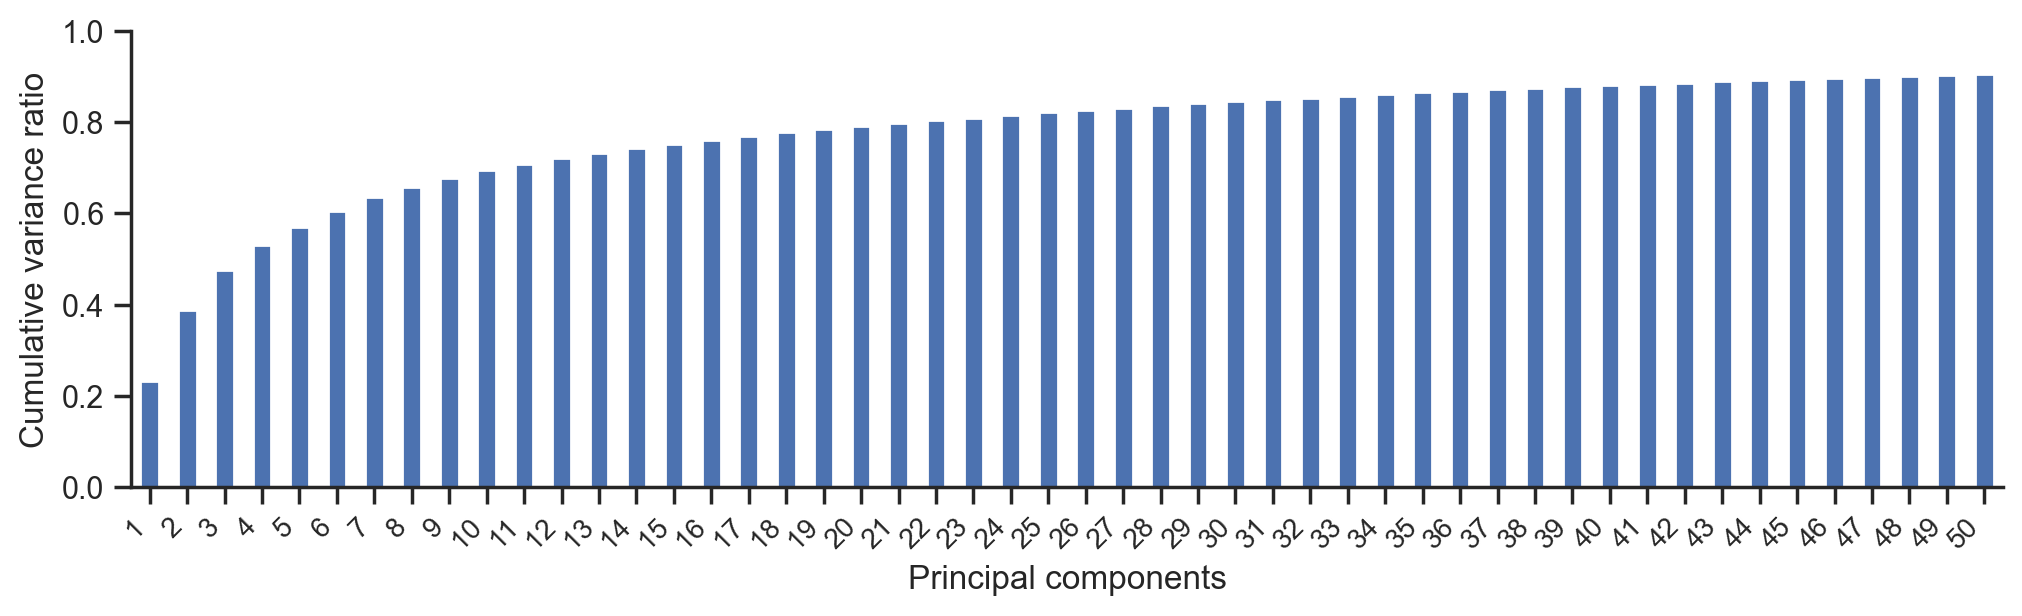

In [15]:
df_cumsum = pd.DataFrame(vrs.cumsum(), index=feat_by_pc.columns)
ax=df_cumsum.plot(kind="bar", figsize=(12,3))
ax.set_ylabel("Cumulative variance ratio")
ax.set_xlabel("Principal components")
ax.set_xticklabels(df_cumsum.index, rotation=0, fontsize=10)
ax.set_ylim(0,1)
ax.spines[['right', 'top']].set_visible(False)
ax.get_legend().remove()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.savefig("cumulative_variance_ratios.pdf", bbox_inches="tight")
plt.show()

In [23]:
adata.write("ROI.h5ad")